# ML Forecasting 

In [38]:
# Normal Libraries
# =======================================================
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.2f}".format

# ML Libraries
# =======================================================
from xgboost import XGBRegressor

from scipy.stats import norm

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals

from sklearn.metrics import mean_squared_error

## Data

In [39]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df["year"] = df["date"].dt.year
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df["Passengers"] = df["Passengers"].astype(float)

    return df 

df = read_dataset()
df

,Passengers,date,year
0,112.00,1949-01-01,1949
1,118.00,1949-02-01,1949
2,132.00,1949-03-01,1949
3,129.00,1949-04-01,1949
4,121.00,1949-05-01,1949
...,...,...,...
139,606.00,1960-08-01,1960
140,508.00,1960-09-01,1960
141,461.00,1960-10-01,1960
142,390.00,1960-11-01,1960


In [40]:
ts_variable = "Passengers"
date_variable = "date"

In [41]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date,year
0,112.00,1949-01-01,1949
1,118.00,1949-02-01,1949
2,132.00,1949-03-01,1949
3,129.00,1949-04-01,1949
4,121.00,1949-05-01,1949
...,...,...,...
110,362.00,1958-03-01,1958
111,348.00,1958-04-01,1958
112,363.00,1958-05-01,1958
113,435.00,1958-06-01,1958


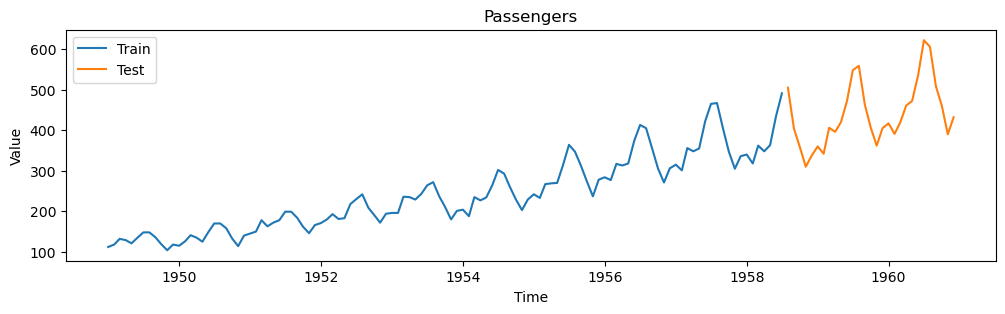

In [42]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

## Dataset Creation

### 1 Step in Future

In [43]:
n_past_steps = 21
train_data = pd.DataFrame()

for i in range(len(train) + 1 - n_past_steps):
    
    cut = train.iloc[i:i+n_past_steps, :].copy()
    row = pd.Series(cut[ts_variable].values)
    train_data = pd.concat([train_data, row], axis = 1)

train_data = train_data.T
train_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))] + ["target"]
train_data
    

,lag_20,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,target
0,112.00,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,...,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00
0,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,...,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00
0,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,...,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00,114.00
0,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,...,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00,114.00,140.00
0,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,...,135.00,125.00,149.00,170.00,170.00,158.00,133.00,114.00,140.00,145.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,413.00,405.00,355.00,306.00,271.00,306.00,315.00,301.00,356.00,348.00,...,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00
0,405.00,355.00,306.00,271.00,306.00,315.00,301.00,356.00,348.00,355.00,...,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00
0,355.00,306.00,271.00,306.00,315.00,301.00,356.00,348.00,355.00,422.00,...,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00
0,306.00,271.00,306.00,315.00,301.00,356.00,348.00,355.00,422.00,465.00,...,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00,435.00


## Model Training

In [44]:
X_train = train_data.drop(columns=["target"])
y_train = train_data["target"]

model = XGBRegressor(n_estimators = 50, random_state = 666)
model.fit(X_train, y_train)

# Performance 
y_train_pred = model.predict(X_train)
print(f'MSE Error: {mean_squared_error(y_train, y_train_pred):.5f}')

MSE Error: 0.00104


### Iterative Forecast

In [45]:
def forecast(train_data, steps = 10):

    predict_data = pd.DataFrame()

    # First Iteration
    forecast_data = pd.DataFrame(train_data.iloc[-1, 1:]).T
    forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))]
    forecast_data = forecast_data.astype(float)
    y_forecast = model.predict(forecast_data)
    forecast_data["target"] = y_forecast

    predict_data = pd.concat([predict_data, forecast_data], axis = 0)

    # Next Iterations
    for _ in range(1, steps):

        forecast_data = pd.DataFrame(predict_data.iloc[-1, 1:]).T
        forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))]
        forecast_data = forecast_data.astype(float)
        y_forecast = model.predict(forecast_data)
        forecast_data["target"] = y_forecast

        predict_data = pd.concat([predict_data, forecast_data], axis = 0)

    return predict_data

predict_data = forecast(train_data, steps = len(test))
predict_data

,lag_20,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,target
0,306.00,315.00,301.00,356.00,348.00,355.00,422.00,465.00,467.00,404.00,...,305.00,336.00,340.00,318.00,362.00,348.00,363.00,435.00,491.00,470.38
0,315.00,301.00,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,...,336.00,340.00,318.00,362.00,348.00,363.00,435.00,491.00,470.38,427.65
0,301.00,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,...,340.00,318.00,362.00,348.00,363.00,435.00,491.00,470.38,427.65,396.43
0,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,...,318.00,362.00,348.00,363.00,435.00,491.00,470.38,427.65,396.43,344.44
0,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,...,362.00,348.00,363.00,435.00,491.00,470.38,427.65,396.43,344.44,339.36
0,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,...,348.00,363.00,435.00,491.00,470.38,427.65,396.43,344.44,339.36,338.88
0,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,...,363.00,435.00,491.00,470.38,427.65,396.43,344.44,339.36,338.88,326.12
0,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,...,435.00,491.00,470.38,427.65,396.43,344.44,339.36,338.88,326.12,349.29
0,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00,...,491.00,470.38,427.65,396.43,344.44,339.36,338.88,326.12,349.29,349.91
0,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00,435.00,...,470.38,427.65,396.43,344.44,339.36,338.88,326.12,349.29,349.91,360.84


In [46]:
print(f'MSE Error Forecast: {mean_squared_error(test[ts_variable], predict_data["target"]):.5f}')

MSE Error Forecast: 6241.92439


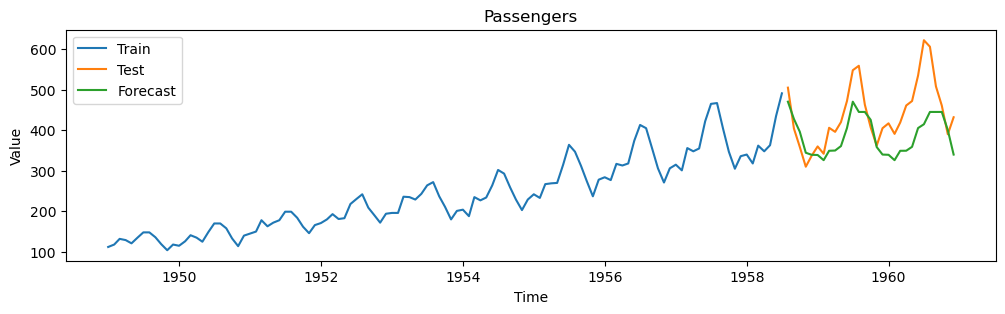

In [47]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.plot(test[date_variable], predict_data["target"], label = f'Forecast')
plt.plot()
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

# SK-Forecast

## Data 

In [48]:
url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv" 
data = pd.read_csv(url, sep=',')
data

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,"4,382.83",21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,"4,263.37",21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,"4,048.97",20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,"3,877.56",20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,"4,036.23",20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,"3,873.45",19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,"3,791.64",18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,"3,724.84",17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,"3,761.89",17.30,2014-12-31,False


In [49]:
def read_dataset():
    
       url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv" 
       data = pd.read_csv(url, sep=',')

       data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
       data = data.set_index('Time')
       data = data.asfreq('30min')
       data = data.sort_index()
       data = data.drop(columns='Date')
       data = data.resample(rule='D', closed='left', label ='right').agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
       
       # Normalize Holiday 
       data["Holiday"] = data["Holiday"].astype(int)
       
       return data 

data = read_dataset()
data

,Demand,Temperature,Holiday
Time,,,
2012-01-01,"82,531.75",21.05,1
2012-01-02,"227,778.26",26.58,1
2012-01-03,"275,490.99",31.75,1
2012-01-04,"258,955.33",24.57,0
2012-01-05,"213,792.38",18.19,0
...,...,...,...
2014-12-28,"173,292.33",18.19,0
2014-12-29,"196,116.23",24.54,0
2014-12-30,"188,570.26",17.68,0


In [50]:
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2014-07-31 23:59:00'
train = data.loc[:end_train, :].copy()
test   = data.loc[end_train:, :].copy()

print(f'{train.shape = }')
print(f'{test.shape = }')

train.shape = (943, 3)
test.shape = (152, 3)


In [51]:
ts_variable = "Demand"
exo_variables = ["Temperature", "Holiday"]

Text(0, 0.5, 'Demand')

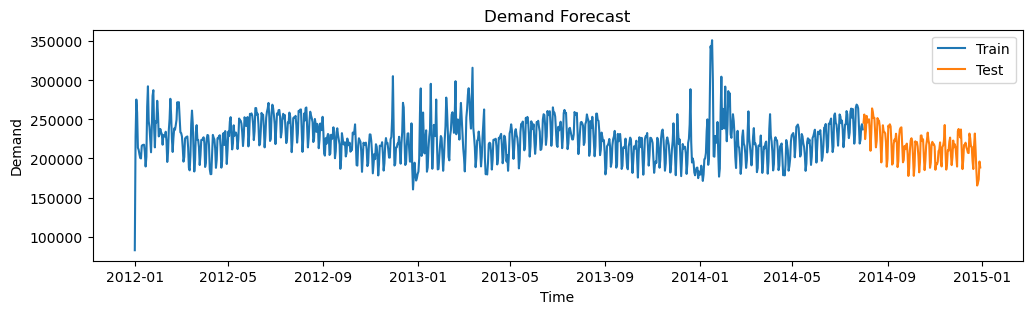

In [52]:
plt.figure(figsize = (12,3))
plt.plot(train.index, train[ts_variable], label = "Train")
plt.plot(test.index, test[ts_variable], label = "Test")
plt.legend()
plt.title("Demand Forecast")
plt.xlabel("Time")
plt.ylabel("Demand")

In [53]:
# Forecaster
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(n_estimators = 50, random_state = 666),
                lags = 14 # Place holder that will be replaced during the search
            )

forecaster.fit(train[ts_variable], exog = train[exo_variables])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=666, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variab

Information of backtesting process
----------------------------------
An already trained forecaster is to be used. Window size: 14
Number of observations used for backtesting: 929
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 943
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 929 observations.

Fold: 0
    Training:   No training in this fold
    Validation: 2012-01-15 00:00:00 -- 2014-07-31 00:00:00  (n=929)



  0%|          | 0/1 [00:00<?, ?it/s]

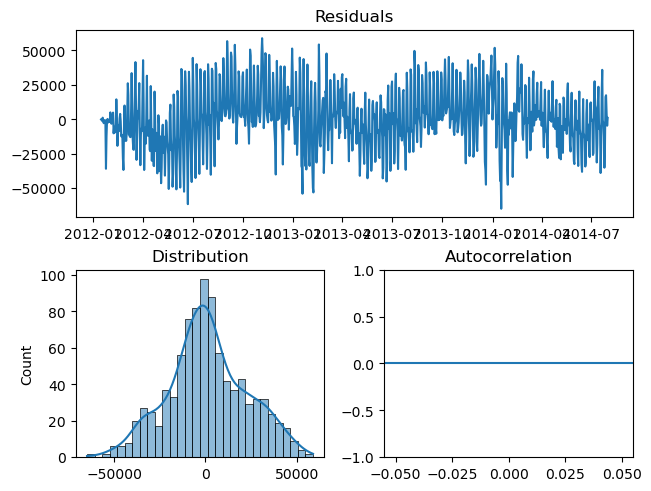

In [54]:
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = train[ts_variable],
                                    steps              = len(train),
                                    exog               = train[exo_variables],
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                               )

residuals = predictions_backtest['pred'] - train[ts_variable]
plot_residuals(residuals=residuals)
plt.savefig("img/residuals.png", dpi = 300, bbox_inches='tight')
plt.show()

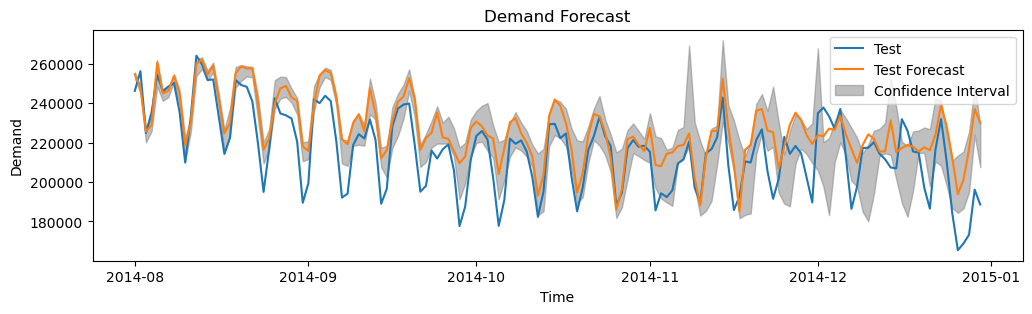

In [55]:
interval_pred = forecaster.predict_interval(steps = len(test), interval = [1, 90], exog = test[exo_variables], n_boot=250)


plt.figure(figsize=(12,3))
# plt.plot(train.index, train[ts_variable], label = f'Train')
plt.plot(test.index, test[ts_variable], label = f'Test')
plt.plot(test.index, interval_pred["pred"], label = f'Test Forecast')
plt.fill_between(test.index, interval_pred["lower_bound"], interval_pred["upper_bound"], color = "gray", label = "Confidence Interval", alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Demand Forecast")
plt.legend()
plt.savefig("img/demand_ml_forecasting.png", dpi = 300, bbox_inches='tight')
plt.show() 

In [56]:
predictions = forecaster.predict_dist(steps=7, distribution=norm, n_boot=1000, exog = test[exo_variables])
predictions

,loc,scale
2014-08-01,"254,758.81",934.99
2014-08-02,"248,120.85","1,009.03"
2014-08-03,"225,306.23","1,627.56"
2014-08-04,"230,625.46","3,856.22"
2014-08-05,"260,100.67","2,685.55"
2014-08-06,"245,020.97","1,126.13"
2014-08-07,"246,529.89","1,204.51"
